In [1]:
!pip uninstall -y scikit-learn imbalanced-learn

Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2


In [2]:
!pip install scikit-learn==1.4.2 imbalanced-learn==0.11.0 

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
    --------------------------------------- 0.3/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.6 MB 799.2 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/10.6 MB 1.4 MB/s eta 0:00:07
   ---------- ----------------------------- 2.9/10.6 MB 3.2 MB/s eta 0:00:03
   ----------------- ---------------------- 4.7/10.6 MB 4.4 MB/s eta 0:00:02
   ------------------------ --------------- 6.6/10.6 MB 5.2 MB/s eta 0:00:01
   --------------------------------- ------ 8.9/10.6 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 6.5 MB/s  0:00:02

   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:
file_paths = {
    'SpamAssasin': "D:\\archive (1)\\SpamAssasin.csv",
    'Nigerian_Fraud': "D:\\archive (1)\\Nigerian_Fraud.csv",
    'Phishing_Email': "D:\\archive (1)\\phishing_email.csv",
    'CEAS_08': "D:\\archive (1)\\CEAS_08.csv",
    'Enron': "D:\\archive (1)\\Enron.csv",
    'Ling': "D:\\archive (1)\\Ling.csv",
    'Nazario': "D:\\archive (1)\\Nazario.csv"
}


In [8]:
datasets = {}
spam_nonspam_counts = {}

for name, path in file_paths.items():
    try:
        df = pd.read_csv(path)
        datasets[name] = df
        
        print(f"\n{name} Dataset:")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        # Check if 'label' column exists
        if 'label' in df.columns:
            spam_count = df[df['label'] == 1].shape[0]
            non_spam_count = df[df['label'] == 0].shape[0]
            print(f"Spam: {spam_count}, Non-spam: {non_spam_count}")
        else:
            spam_count = df.shape[0]
            non_spam_count = 0
            print(f"All emails considered as spam: {spam_count}")
        
        spam_nonspam_counts[name] = {
            'spam_count': spam_count,
            'non_spam_count': non_spam_count
        }
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {name}: {str(e)}")
        
# Display summary
print("\n" + "="*50)
print("SUMMARY OF ALL DATASETS:")
print("="*50)
for dataset, counts in spam_nonspam_counts.items():
    print(f"{dataset}: {counts['spam_count']} spam, {counts['non_spam_count']} non-spam")


SpamAssasin Dataset:
Shape: (5809, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Spam: 1718, Non-spam: 4091

Nigerian_Fraud Dataset:
Shape: (3332, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Spam: 3332, Non-spam: 0

Phishing_Email Dataset:
Shape: (82486, 2)
Columns: ['text_combined', 'label']
Spam: 42891, Non-spam: 39595

CEAS_08 Dataset:
Shape: (39154, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
Spam: 21842, Non-spam: 17312

Enron Dataset:
Shape: (29767, 3)
Columns: ['subject', 'body', 'label']
Spam: 13976, Non-spam: 15791

Ling Dataset:
Shape: (2859, 3)
Columns: ['subject', 'body', 'label']
Spam: 458, Non-spam: 2401

Nazario Dataset:
Shape: (1565, 7)
Columns: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']
Spam: 1565, Non-spam: 0

SUMMARY OF ALL DATASETS:
SpamAssasin: 1718 spam, 4091 non-spam
Nigerian_Fraud: 3332 spam, 0 non-spam
Phishing_Email: 42891 spam, 39595

In [10]:
def preprocess_text(df):
    """Basic text preprocessing"""
    df = df.copy()
    
    # Remove null values
    df = df.dropna(subset=['text'])
    
    # Convert text to lowercase
    df['text'] = df['text'].astype(str).str.lower()
    
    # Remove extra whitespace
    df['text'] = df['text'].str.strip()
    
    # Remove empty strings
    df = df[df['text'].str.len() > 0]
    
    return df

# Combine datasets that have text content
combined_data = []

for name, df in datasets.items():
    print(f"\nProcessing {name}...")
    
    # Check for text columns
    text_column = None
    if 'text_combined' in df.columns:
        text_column = 'text_combined'
    elif 'text' in df.columns:
        text_column = 'text'
    elif 'body' in df.columns:
        text_column = 'body'
    elif 'content' in df.columns:
        text_column = 'content'
    
    if text_column:
        # Prepare dataframe
        df_subset = df[[text_column]].copy()
        
        # Add label column
        if 'label' in df.columns:
            df_subset['label'] = df['label']
        else:
            df_subset['label'] = 1  # Assume all are spam
        
        # Rename text column
        df_subset.columns = ['text', 'label']
         # Add dataset source
        df_subset['source'] = name
        
        combined_data.append(df_subset)
        print(f"Added {len(df_subset)} emails from {name}")
    else:
        print(f"No text column found in {name}")

# Combine all datasets
if combined_data:
    combined_df = pd.concat(combined_data, ignore_index=True)
    print(f"\nCombined dataset created with {len(combined_df)} emails")
    
    # Preprocess text
    combined_df = preprocess_text(combined_df)
    print(f"After preprocessing: {len(combined_df)} emails")
    
    # Show class distribution
    print(f"\nClass distribution:")
    print(combined_df['label'].value_counts())
    
    # Show source distribution
    print(f"\nSource distribution:")
    print(combined_df['source'].value_counts())
    
    # Show sample data
    print(f"\nSample data:")
    print(combined_df.head())
    
else:
    print("No datasets with text content found!")


Processing SpamAssasin...
Added 5809 emails from SpamAssasin

Processing Nigerian_Fraud...
Added 3332 emails from Nigerian_Fraud

Processing Phishing_Email...
Added 82486 emails from Phishing_Email

Processing CEAS_08...
Added 39154 emails from CEAS_08

Processing Enron...
Added 29767 emails from Enron

Processing Ling...
Added 2859 emails from Ling

Processing Nazario...
Added 1565 emails from Nazario

Combined dataset created with 164972 emails
After preprocessing: 164966 emails

Class distribution:
label
1    85776
0    79190
Name: count, dtype: int64

Source distribution:
source
Phishing_Email    82485
CEAS_08           39154
Enron             29767
SpamAssasin        5807
Nigerian_Fraud     3331
Ling               2859
Nazario            1563
Name: count, dtype: int64

Sample data:
                                                text  label       source
0  date:        wed, 21 aug 2002 10:54:46 -0500  ...      0  SpamAssasin
1  martin a posted:\ntassos papadopoulos, the gre...   

In [11]:

X = combined_df['text']
y = combined_df['label']

print(f"Total samples: {len(X)}")
print(f"Class distribution: {Counter(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")

Total samples: 164966
Class distribution: Counter({1: 85776, 0: 79190})

Training set size: 131972
Test set size: 32994
Training class distribution: Counter({1: 68620, 0: 63352})
Test class distribution: Counter({1: 17156, 0: 15838})


In [12]:
# =============================================================================
# CELL 6: Create SVM Pipeline
# =============================================================================

def create_svm_pipeline(use_undersampling=True, max_features=1000):
    """Create SVM pipeline with optional undersampling"""
    
    if use_undersampling:
        # Pipeline with undersampling
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer(
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('undersampler', RandomUnderSampler(random_state=42)),
            ('svm', SVC(
                kernel='linear',
                C=1.0,
                probability=False,
                random_state=42
            ))
        ])
    else:
        # Pipeline without undersampling
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=max_features,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95,
                lowercase=True,
                strip_accents='unicode'
            )),
            ('svm', SVC(
                kernel='linear',
                C=1.0,
                probability=False,
                random_state=42
            ))
        ])
    
    return pipeline

# Create pipeline
print("Creating SVM pipeline...")
pipeline = create_svm_pipeline(use_undersampling=False, max_features=1000)
print("Pipeline created successfully!")
print(f"Pipeline steps: {list(pipeline.named_steps.keys())}")

Creating SVM pipeline...
Pipeline created successfully!
Pipeline steps: ['tfidf', 'svm']


In [13]:
print("Training SVM model...")
print("This may take a few minutes...")

# Train the model
pipeline.fit(X_train, y_train)

print("Model training completed!")

Training SVM model...
This may take a few minutes...
Model training completed!


In [14]:
import joblib

joblib.dump(pipeline, 'svm_email_classifier.pkl')

['svm_email_classifier.pkl']

Making predictions...
Test Accuracy: 0.9628

Classification Report:
              precision    recall  f1-score   support

    Non-Spam       0.97      0.95      0.96     15838
        Spam       0.96      0.97      0.96     17156

    accuracy                           0.96     32994
   macro avg       0.96      0.96      0.96     32994
weighted avg       0.96      0.96      0.96     32994


Confusion Matrix:
[[15093   745]
 [  483 16673]]


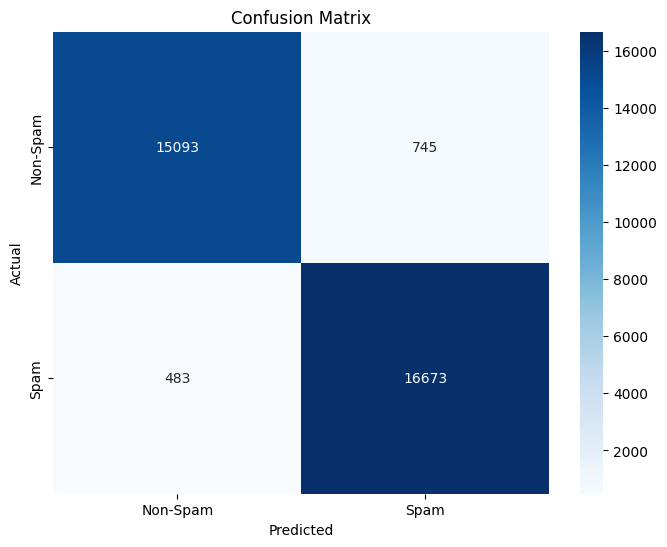

In [15]:
def evaluate_model(pipeline, X_test, y_test, class_names=['Non-Spam', 'Spam']):
    """Evaluate the trained model (no predict_proba)"""
    
    # Make predictions
    print("Making predictions...")
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    return accuracy, y_pred

# Evaluate the model
accuracy, y_pred = evaluate_model(pipeline, X_test, y_test)


Performing cross-validation...
This may take a few minutes...
Cross-validation scores: [0.96325062 0.96181095 0.96199894 0.96162007 0.963325  ]
Mean CV score: 0.9624 (+/- 0.0015)


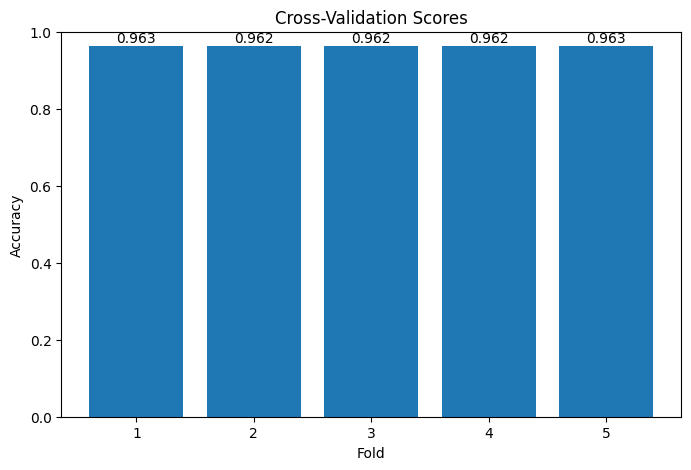

In [16]:


print("Performing cross-validation...")
print("This may take a few minutes...")

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Plot CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.ylim(0, 1)
for i, score in enumerate(cv_scores):
    plt.text(i+1, score + 0.01, f'{score:.3f}', ha='center')
plt.show()

Top 15 features indicating SPAM:
--------------------------------------------------
2004: 5.8436
investors: 4.3739
2005: 3.9318
guaranteed: 3.7986
investment: 3.5733
aug 2008: 3.4467
remove: 3.4013
statements: 3.2478
dear: 3.2345
rolex: 3.2338
life: 3.0343
daily 10: 2.9061
sex: 2.8561
dollars: 2.8510
partner: 2.7772

Top 15 features indicating NON-SPAM:
--------------------------------------------------
enron: -10.4316
wrote: -9.7552
vince: -6.4648
opensuse: -5.9337
louise: -5.9199
713: -5.8349
forwarded: -5.8098
thanks: -5.4920
2008: -5.0119
edu: -4.6878
university: -4.6801
bug: -4.5577
kaminski: -4.3825
linguistics: -4.2854
date: -4.2682


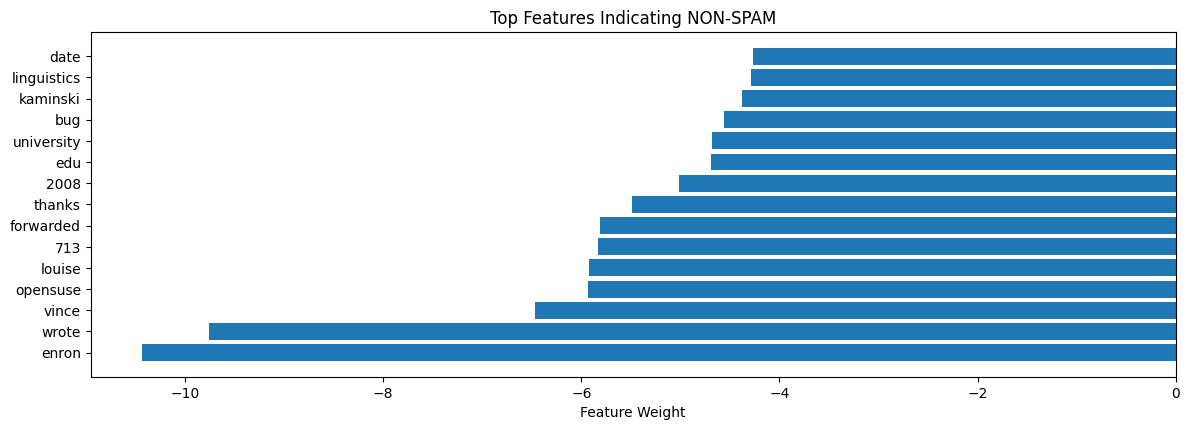

In [17]:
def analyze_feature_importance(pipeline, top_n=20):
    """Analyze most important features in the SVM model"""
    
    # Get feature names
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    
    # Get SVM coefficients as dense array
    svm_coef = pipeline.named_steps['svm'].coef_.toarray().flatten()
    
    # Get top positive and negative features
    top_positive_idx = np.argsort(svm_coef)[-top_n:]
    top_negative_idx = np.argsort(svm_coef)[:top_n]
    
    print(f"Top {top_n} features indicating SPAM:")
    print("-" * 50)
    for idx in reversed(top_positive_idx):
        print(f"{feature_names[idx]}: {svm_coef[idx]:.4f}")
    
    print(f"\nTop {top_n} features indicating NON-SPAM:")
    print("-" * 50)
    for idx in top_negative_idx:
        print(f"{feature_names[idx]}: {svm_coef[idx]:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    
    # Top spam features
    plt.subplot(2, 1, 2)
    nonspam_features = [feature_names[idx] for idx in top_negative_idx]
    nonspam_scores = [svm_coef[idx] for idx in top_negative_idx]
    plt.barh(range(len(nonspam_features)), nonspam_scores)
    plt.yticks(range(len(nonspam_features)), nonspam_features)
    plt.xlabel('Feature Weight')
    plt.title('Top Features Indicating NON-SPAM')
    
    plt.tight_layout()
    plt.show()
analyze_feature_importance(pipeline, top_n=15)

In [18]:
sample_emails = [
    "Congratulations! You have won $1,000,000 in our lottery! Click here to claim your prize immediately!",
    "Hi John, can you please send me the report by tomorrow? Thanks!",
    "URGENT: Your account will be suspended unless you verify your information now. Click here immediately!",
    "Meeting scheduled for next Tuesday at 2 PM. Please confirm your attendance.",
    "FREE MONEY! Get rich quick! No work required! Click now!",
    "Your order has been shipped and will arrive in 2-3 business days.",
    "WINNER! You are selected for our special promotion. Send us your bank details now!",
    "Please review the attached document and let me know your feedback."
]

print("Testing with sample emails:")
print("=" * 80)

for i, email in enumerate(sample_emails, 1):
    pred = pipeline.predict([email])[0]
    # proba = pipeline.predict_proba([email])[0]
    
    print(f"\nEmail {i}:")
    print(f"Text: {email}")
    print(f"Prediction: {'SPAM' if pred == 1 else 'NON-SPAM'}")
    # print(f"Spam Probability: {proba[1]:.4f}")
    # print(f"Non-Spam Probability: {proba[0]:.4f}")
    print("-" * 80)

Testing with sample emails:

Email 1:
Text: Congratulations! You have won $1,000,000 in our lottery! Click here to claim your prize immediately!
Prediction: SPAM
--------------------------------------------------------------------------------

Email 2:
Text: Hi John, can you please send me the report by tomorrow? Thanks!
Prediction: NON-SPAM
--------------------------------------------------------------------------------

Email 3:
Text: URGENT: Your account will be suspended unless you verify your information now. Click here immediately!
Prediction: SPAM
--------------------------------------------------------------------------------

Email 4:
Text: Meeting scheduled for next Tuesday at 2 PM. Please confirm your attendance.
Prediction: NON-SPAM
--------------------------------------------------------------------------------

Email 5:
Text: FREE MONEY! Get rich quick! No work required! Click now!
Prediction: SPAM
--------------------------------------------------------------------------

In [19]:
import joblib
import os
import json
from sklearn.metrics import confusion_matrix

# Create directory for saving model
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)

# Save the trained pipeline
model_path = os.path.join(save_dir, 'svm_phishing_detector.pkl')
joblib.dump(pipeline, model_path)
print(f"✅ Model saved to: {model_path}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Prepare metrics for saving (convert ndarray to list)
metrics = {
    'accuracy': float(accuracy),
    'cv_scores': cv_scores.tolist(),
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'confusion_matrix': cm.tolist()
}
metrics_path = os.path.join(save_dir, 'model_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"✅ Metrics saved to: {metrics_path}")

# Summary output
print("\n📊 Model training and evaluation completed successfully!")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Cross-validation Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


✅ Model saved to: /kaggle/working/models\svm_phishing_detector.pkl
✅ Metrics saved to: /kaggle/working/models\model_metrics.json

📊 Model training and evaluation completed successfully!
Final Test Accuracy: 0.9628
Cross-validation Mean: 0.9624 (+/- 0.0015)
